In [1]:
from robust_motifs.data import load_sparse_matrix_from_pkl
import numpy as np

In [2]:
from pathlib import Path
import pickle

In [3]:
import matplotlib.pyplot as plt

In [4]:
def average_correlations(gids, gid_start, gid_end, corr_matrix, conn_matrix):
    dvalues = []
    bvalues = []
    dvariances = []
    bvariances = []
    values = []
    variances = []
    btot = []
    dtot = []
    tot = []
    edges = np.hstack([np.expand_dims(elem, axis = 1) for elem in np.nonzero(conn_matrix)])
    posarray = np.empty((gid_end - gid_start + 1,))
    posarray[:] = np.nan
    for j, element in enumerate(gids - gid_start):
        posarray[element] = j

    dcorrelations = np.empty((edges.shape[0],))
    dcorrelations[:] = np.nan
    bcorrelations = np.empty((edges.shape[0],))
    bcorrelations[:] = np.nan
    correlations = np.empty((edges.shape[0],))
    correlations[:] = np.nan
    extra_count = 0
    for j, (row, col) in enumerate(edges):
        if np.isnan(posarray[row]) or np.isnan(posarray[col]):
            value = 0
        else:
            value = corr_matrix[int(posarray[row])][int(posarray[col])]
        if conn_matrix[col, row]:
            bcorrelations[j] = value
        else:
            dcorrelations[j] = value
        correlations[j] = value
    return np.nanmean(bcorrelations), np.nanmean(correlations)

# All

### Evoked

In [5]:
abid = np.zeros((6,), dtype = float)
adir = np.zeros((6,), dtype = float)
aall = np.zeros((6,), dtype = float)

bbid = np.zeros((6,), dtype = float)
bdir = np.zeros((6,), dtype = float)
ball = np.zeros((6,), dtype = float)

correlations = []
bcorrelations = []

matrix = load_sparse_matrix_from_pkl(Path("data/activity/network/cons_locs_pathways_mc2_Column/cons_locs_pathways_mc2_Column.pkl"))
matrix = np.array(matrix.todense())

for seed in Path("data/activity/spikes/evoked").glob("*"):
    a = pickle.load(open(seed / "simplexwise_pc_all.pkl", 'rb'))
    abid += a[0][0]
    adir += a[1][0]
    aall += a[2][0]
    b = pickle.load(open(seed / "bisimplexwise_pc_all.pkl", 'rb'))
    bbid += b[0][0]
    bdir += b[1][0]
    ball += b[2][0]
    
    gids = pickle.load(open(seed / "gids.pkl", 'rb'))
    corr_matrix = pickle.load(open(seed/"pearson_correlation.pkl", 'rb'))
    bcorrelation, correlation = average_correlations(gids, 62693, 94038, corr_matrix, matrix)
    correlations.append(correlation)
    bcorrelations.append(bcorrelation)
abid/=20
adir/=20
aall/=20
bbid/=20
bdir/=20
ball/=20

average_correlation = np.mean(correlations)
average_bicorrelation = np.mean(bcorrelations)

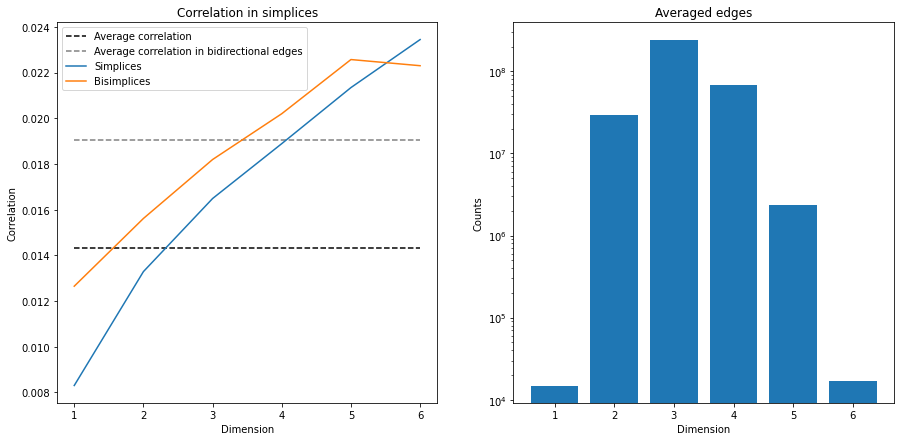

In [6]:
fig, axes = plt.subplots(1,2, figsize = [15, 7])
axes[0].errorbar(range(1,7), aall, label = 'Simplices')
axes[0].errorbar(range(1,7), ball, label = 'Bisimplices')
axes[0].hlines(average_correlation, xmin = 1, xmax = 6, colors = "black", label = "Average correlation", linestyles = 'dashed')
axes[0].hlines(average_bicorrelation, xmin = 1, xmax = 6, colors = "gray", label = "Average correlation in bidirectional edges", linestyles = 'dashed')
axes[0].set_xlabel("Dimension")
axes[0].set_ylabel("Correlation")
axes[0].set_title("Correlation in simplices")
axes[0].legend()

axes[1].bar(np.arange(1,7), a[2][2])
axes[1].set_xlabel("Dimension")
axes[1].set_ylabel("Counts")
axes[1].set_title("Averaged edges")
axes[1].set_yscale('log')
fig.savefig("comparison_all_evoked", facecolor = 'white')